## Gait Video Study 
### Traditional ML algorithms on task+subject generalization together frameworks, namely a) train on some subjects in W-> test on separate set of subjects in WT and b) train on some subjects in VBW-> test on separate set of subjects in VBWT to classify HOA/MS/PD strides and subjects 
#### Remember to add the original count of frames in a single stride (before down sampling via smoothing) for each stride as an additional artificial feature to add information about speed of the subject to the model

1. Save the optimal hyperparameters, confusion matrices and ROC curves for each algorithm.
2. Make sure to not use x, y, z, confidence = 0, 0, 0, 0 as points for the model since they are simply missing values and not data points, so make sure to treat them before inputting to model 
3. Make sure to normalize (z-score normalization) the features before we feed them to the model.
4. We use the summary statistics as range, CoV and asymmetry between the right and left limbs as the features to input to the traditional models requiring fixed size 1D input for each training/testing set sample.
5. For implementation of task+subject generalization together framework 1: i.e. train on some subjects in W and test on remaining separate set of subjects in WT,  since we have 32 subjects in training/W and 26 subjects in testing/WT and 25 subjects that are common in both W and WT. We always keep the (32-25) = 7 subjects only available in W in training and always keep (26-25) = 1 subject only available in WT in testing along with cross validation folds created for training and testing sets from the 25 common subjects in both. So, basically, for 5 fold cross validation on 25 common subjects, we train on 20 + 7 subjects and test on 5+1 subjects where these 20 and 5 subjects keep on changing with each fold, but the 7 and 1 subjects remain the same.
6. We use stratified group 5 fold cross validation.

In [1]:
from importlib import reload
import imports 
reload(imports)
from imports import *
from split import StratifiedGroupKFold

In [2]:
path = 'C:\\Users\\Rachneet Kaur\\Box\\Gait Video Project\\GaitVideoData\\video\\'
data_path = path+'traditional_methods_dataframe.csv'
results_path = 'C:\\Users\\Rachneet Kaur\\Box\Gait Video Project\\MLresults\\'

data = pd.read_csv(data_path, index_col= 0)
display(data.head())

,key,cohort,trial,scenario,video,PID,stride_number,frame_count,label,right hip-x-CoV,...,ankle-z-asymmetry,heel-x-asymmetry,heel-y-asymmetry,heel-z-asymmetry,toe 1-x-asymmetry,toe 1-y-asymmetry,toe 1-z-asymmetry,toe 2-x-asymmetry,toe 2-y-asymmetry,toe 2-z-asymmetry
0,GVS_212_T_T1_1,HOA,BW,SLWT,GVS_212_T_T1,212,1,46,0,0.046077,...,14.426173,3.407379,10.662441,0.830365,0.502570,31.450487,8.644012,5.236678,31.182183,8.215725
1,GVS_212_T_T1_2,HOA,BW,SLWT,GVS_212_T_T1,212,2,39,0,0.021528,...,1.360847,5.155307,11.363806,4.333776,1.025647,28.266400,2.671081,6.678294,15.058825,4.903579
2,GVS_212_T_T1_3,HOA,BW,SLWT,GVS_212_T_T1,212,3,56,0,0.034394,...,1.341021,8.625363,7.159495,3.366152,1.759968,17.545787,5.921325,8.243491,9.578638,3.008162
3,GVS_212_T_T1_4,HOA,BW,SLWT,GVS_212_T_T1,212,4,53,0,0.028511,...,2.375934,6.728268,0.098235,0.999027,0.541911,7.843339,4.279617,0.748023,19.471731,5.086056
4,GVS_212_T_T1_5,HOA,BW,SLWT,GVS_212_T_T1,212,5,44,0,0.025213,...,8.525816,1.775282,0.033210,9.166863,1.354601,6.674183,8.479480,4.373622,0.315168,11.795593


### Utility functions

In [3]:
def extract_train_test_common_PIDs(data, train_framework = 'W', test_framework = 'WT'):
    '''
    Since we need to train on some subjects of W/VBW and test on remaining subjects of WT/VBWT respectively, we keep subjects that 
    only belong to W/VBW and not to WT/VBWT as only training subjects and similarly subjects that belong to only WT/VBWT as only testing 
    subjects. Further, for common subjects in training and testing, we use 5-fold cross validation. 
    
    For implementation of task+subject generalization together framework 1: i.e. train on some subjects in W and test on 
    remaining separate set of subjects in WT,  since we have 32 subjects in training/W and 26 subjects in testing/WT and 
    25 subjects that are common in both W and WT. We always keep the (32-25) = 7 subjects only available in W in training and 
    always keep (26-25) = 1 subject only available in WT in testing along with cross validation folds created for training and 
    testing sets from the 25 common subjects in both. So, basically, for 5 fold cross validation on 25 common subjects, we train 
    on 20 + 7 subjects and test on 5+1 subjects where these 20 and 5 subjects keep on changing with each fold, but the 7 and 1 
    subjects remain the same.
    Arguments: 
        data: labels.csv file with all consolidated information,
        train_framework: Training framework
        test_framework: Testing framework
    Returns: 
        train_pids: list of PIDs/subjects that are only included in the training set 
        test_pids: list of PIDs/subjects that are only included in the test set
        common_pids: list of common PIDs/subjects across the training and test set to be used for CV 
    '''
    
    original_pids = {} #Dictionary with original number of PIDs in each framework (task)
    #Appending the original PIDs for each task
    original_pids[train_framework] = data[data.scenario==train_framework].PID.unique()
    original_pids[test_framework] = data[data.scenario==test_framework].PID.unique()
    print ('Original number of subjects in training task', train_framework, 'are:', len(original_pids[train_framework]))
    print ('Original number of subjects in testing task', test_framework, 'are:', len(original_pids[test_framework]))
    
    #List of common PIDs across the train and test frameworks
    common_pids = list(set(original_pids[train_framework]) & set(original_pids[test_framework]))
    print ('Common number of subjects across train and test frameworks: ', len(common_pids))
    print ('Common subjects across train and test frameworks: ', common_pids)
    #List of PIDs only in the training set but not in the test set
    train_pids = list(set(original_pids[train_framework])^set(common_pids))
    print ('Number of subjects only in training framework: ', len(train_pids))
    print ('Subjects only in training framework: ', train_pids)
    #List of PIDs only in the testing set but not in the training set
    test_pids = list(set(original_pids[test_framework])^set(common_pids))
    print ('Number of subjects only in test framework: ', len(test_pids))
    print ('Subjects only in test framework: ', test_pids)    
    return train_pids, test_pids, common_pids

In [4]:
def compute_train_test_indices_split(train_test_concatenated, X_train_common, Y_train_common, train_pids, test_pids, \
                                     train_framework, test_framework):
    '''
    For task+subject generalization framework, since our train and test indices are custom made, i.e. train indices are from
    trial W and test indices are from trial WT. Further, since 7 subjects only exist in trial W, we include them only in 
    training indices and 1 subject only exists in trial WT, we include them only in testing indices. For other 25 common
    subjects we do stratified group five fold cross validation based on subject PIDs and thus no same subject can have strides 
    both in training and in validation sets. We add the strides from 7 only training subjects to strides assigned via CV to training
    and similarly add the strides from 1 only testing subject to strides assigned via CV to testing. Thus the training only and 
    testing only strides remain common in all folds. 
    Arguments:
        train_test_concatenated: the concatendated dataframe with both training and testing strides appended 
        X_train_common: X (including 91 features) for training set with common PIDs only 
        Y_train_common: Y (labels) for training set with common PIDs only 
        train_pids: PIDs for subjects that only exist in training 
        test_pids: PIDs for subjects that only exist in testing 
        train_framework: training task 
        test_framework: testing task 
    Returns:
        train_indices: list of lists of .iloc indices for training folds 
        test_indices: list of lists of .iloc indices for testing folds 
    '''
    #List to append lists of training and test indices for each CV fold
    train_indices, test_indices = [], []
    #PIDs define the groups for stratified group 5-fold CV
    groups_ = Y_train_common['PID']

    #We use stratified group K-fold to sample our strides data
    gkf = StratifiedGroupKFold(n_splits=5) 

    #Indices for strides of subjects that exist only in training set 
    train_only_indices = train_test_concatenated[(train_test_concatenated.PID.isin(train_pids)) \
                                                 & (train_test_concatenated.scenario==train_framework)].index
    #Indices for strides of subjects that exist only in testing set 
    test_only_indices = train_test_concatenated[(train_test_concatenated.PID.isin(test_pids)) \
                                                 & (train_test_concatenated.scenario==test_framework)].index

    #Computing the CV fold indices for common subjects in training and testing 
    for train_idx, test_idx in gkf.split(X_train_common, Y_train_common['label'], groups=groups_):
        #PIDs for train indices using Stratified group 5-fold split
        train_split_pids = groups_.iloc[train_idx].unique()
    #     print ('train_pids', train_split_pids)
        #Indices for training using CV split in each fold 
        train_split_indices = train_test_concatenated[(train_test_concatenated.PID.isin(train_split_pids)) \
                                                     & (train_test_concatenated.scenario==train_framework)].index
        #Concatenating the indices of strides for PIDs in training only and CV split training PIDs 
        train_split_indices = train_split_indices.union(train_only_indices)
    #     print (train_split_indices, train_split_indices.shape)
        #Appending the training indices for the current fold 
        train_indices.append(train_split_indices)

        #PIDs for test indices using Stratified group 5-fold split
        test_split_pids = groups_.iloc[test_idx].unique()
    #     print ('test_pids', test_split_pids)
        #Indices for testing using CV split in each fold 
        test_split_indices = train_test_concatenated[(train_test_concatenated.PID.isin(test_split_pids)) \
                                                     & (train_test_concatenated.scenario==test_framework)].index
        #Concatenating the indices of strides for PIDs in testing only and CV split testing PIDs 
        test_split_indices = test_split_indices.union(test_only_indices)
    #     print (test_split_indices, test_split_indices.shape)
        #Appending the testing indices for the current fold 
        test_indices.append(test_split_indices)
    
    #Computing the .iloc indices from the .loc indices of the training and testing strides 
    train_indices = [train_test_concatenated.reset_index().index[train_test_concatenated.index.isin(train_indices[i])] for i in range(len(train_indices))]
    test_indices = [train_test_concatenated.reset_index().index[train_test_concatenated.index.isin(test_indices[i])] for i in range(len(test_indices))]
    return train_indices, test_indices

In [5]:
def evaluate(model, test_features, yoriginal_, ypredicted_, framework, model_name):
#     print ('yoriginal_', yoriginal_)
#     print ('ypredicted_', ypredicted_)
    '''
    Arguments: trained model, test set, true and predicted labels for test set, framework and model name 
    Returns: predicted probabilities and labels for each class, stride and subject based evaluation metrics 
    Saves the csv files for stride wise predictions and subject wise predictions for confusion matrix 
    '''
    #For creating the stride wise confusion matrix, we append the true and predicted labels for strides in each fold to this 
    #test_strides_true_predicted_labels dataframe 
    test_strides_true_predicted_labels = pd.DataFrame()
    #For creating the subject wise confusion matrix, we append the true and predicted labels for subjects in each fold to this
    #test_subjects_true_predicted_labels dataframe
    test_subjects_true_predicted_labels = pd.DataFrame()
    
    best_index = model.cv_results_['mean_test_accuracy'].argmax()
    print('best_params: ', model.cv_results_['params'][best_index])

    #Stride-wise metrics 
    stride_metrics_mean, stride_metrics_std = [], [] #Mean and SD of stride based metrics - Acc, P, R, F1, AUC (in order)
    scores={'accuracy': make_scorer(acc), 'precision':make_scorer(precision_score, average = 'macro'), \
            'recall':make_scorer(recall_score, average = 'macro'), 'f1': make_scorer(f1_score, average = 'macro'), \
           'auc': make_scorer(roc_auc_score, average = 'macro', multi_class = 'ovo', needs_proba= True)}
    
    for score in scores:
        stride_metrics_mean.append(model.cv_results_['mean_test_'+score][best_index])
        stride_metrics_std.append(model.cv_results_['std_test_'+score][best_index])
    print('Stride-based model performance (mean): ', stride_metrics_mean)
    print('Stride-based model performance (standard deviation): ', stride_metrics_std)
    n_folds = 5
    person_acc, person_p, person_r, person_f1, person_auc = [], [], [], [], []

    for i in range(n_folds):
        #For each fold, there are 2 splits: test and train (in order) and we need to retrieve the index 
        #of only test set for required 5 folds (best index)
        temp = test_features.loc[yoriginal_[(best_index*n_folds) + (i)].index] #True labels for the test strides in each fold
        temp['pred'] = ypredicted_[(best_index*n_folds) + (i)] #Predicted labels for the strides in the test set in each fold
#         display('temp', temp)
#         print ('temp_pred', temp['pred'])
        #Appending the test strides' true and predicted label for each fold to compute stride-wise confusion matrix 
        test_strides_true_predicted_labels = test_strides_true_predicted_labels.append(temp)
        
        x = temp.groupby('PID')['pred'].value_counts().unstack()
#         print ('x', x)
        #Input for subject wise AUC is probabilities at columns [0, 1, 2]
        proportion_strides_correct = pd.DataFrame(columns = [0, 1, 2])
        probs_stride_wise = x.divide(x.sum(axis = 1), axis = 0).fillna(0)
        proportion_strides_correct[probs_stride_wise.columns] = probs_stride_wise
        proportion_strides_correct.fillna(0, inplace=True)
        proportion_strides_correct['True Label'] = test_features.groupby('PID').first()
        #Input for precision, recall and F1 score
        proportion_strides_correct['Predicted Label'] = proportion_strides_correct[[0, 1, 2]].idxmax(axis = 1) 
        #Appending the test subjects' true and predicted label for each fold to compute subject-wise confusion matrix 
        test_subjects_true_predicted_labels = test_subjects_true_predicted_labels.append(proportion_strides_correct)          
            
        #Person wise metrics for each fold 
        person_acc.append(accuracy_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_p.append(precision_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'], \
                                       average = 'macro'))
        person_r.append(recall_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'], \
                                    average = 'macro'))
        person_f1.append(f1_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'], \
                                  average = 'macro'))
        person_auc.append(roc_auc_score(proportion_strides_correct['True Label'], proportion_strides_correct[[0, 1, 2]], \
                                        multi_class = 'ovo', average= 'macro'))

    #Mean and standard deviation for person-based metrics 
    person_means = [np.mean(person_acc), np.mean(person_p), np.mean(person_r), np.mean(person_f1), np.mean(person_auc)]
    person_stds = [np.std(person_acc), np.std(person_p), np.std(person_r), np.std(person_f1), np.std(person_auc)]
    print('Person-based model performance (mean): ', person_means)
    print('Person-based model performance (standard deviation): ', person_stds)
    
    #Saving the stride and person wise true and predicted labels for calculating the 
    #stride and subject wise confusion matrix for each model
    test_strides_true_predicted_labels.to_csv(results_path+ framework + '\\stride_wise_predictions_' + \
                                      str(model_name) + '_' + framework + '.csv')
    test_subjects_true_predicted_labels.to_csv(results_path+ framework + '\\person_wise_predictions_' + \
                                      str(model_name) + '_' + framework + '.csv')
    
    return test_subjects_true_predicted_labels, [stride_metrics_mean, stride_metrics_std, person_means, person_stds]

In [6]:
def acc(y_true,y_pred):
    '''
    Returns the accuracy 
    Saves the true and predicted labels for training and test sets
    '''
    global yoriginal, ypredicted
    yoriginal.append(y_true)
    ypredicted.append(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [7]:
#We do not use LDA/QDA since our features are not normally distributed 
def models(X, Y, train_indices, test_indices, model_name = 'random_forest', framework = 'W'):
    '''
    Arguments:
    X, Y, PID groups so that strides of each person are either in training or in testing set
    model: model_name, framework we wish to run the code for
    Returns: predicted probabilities and labels for each class, stride and subject based evaluation metrics 
    '''
    Y_ = Y['label'] #Dropping the PID
    groups_ = Y['PID']
    scores={'accuracy': make_scorer(acc), 'precision':make_scorer(precision_score, average = 'macro'), \
            'recall':make_scorer(recall_score, average = 'macro'), 'f1': make_scorer(f1_score, average = 'macro'), \
            'auc': make_scorer(roc_auc_score, average = 'macro', multi_class = 'ovo', needs_proba=True)}
    if(model_name == 'random_forest'): #Random Forest
        grid = {
       'randomforestclassifier__n_estimators': [40,45,50],\
       'randomforestclassifier__max_depth' : [15,20,25,None],\
       'randomforestclassifier__class_weight': [None, 'balanced'],\
       'randomforestclassifier__max_features': ['auto','sqrt','log2', None],\
       'randomforestclassifier__min_samples_leaf':[1,2,0.1,0.05]
        }
        #For z-score scaling on training and use calculated coefficients on test set
        rf_grid = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=0))
        grid_search = GridSearchCV(rf_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=zip(train_indices, test_indices), refit=False)
    
    if(model_name == 'adaboost'): #Adaboost
        ada_grid = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=0))
        grid = {
        'adaboostclassifier__n_estimators':[50, 75, 100, 125, 150],\
        'adaboostclassifier__learning_rate':[0.01,.1, 1, 1.5, 2]\
        }
        grid_search = GridSearchCV(ada_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=zip(train_indices, test_indices), refit=False)
        
    if(model_name == 'kernel_svm'): #RBF SVM
        svc_grid = make_pipeline(StandardScaler(), SVC(kernel = 'rbf', probability=True, random_state=0))
        grid = {
        'svc__gamma':[0.0001, 0.001, 0.1, 1, 10, ]\
        }
        grid_search = GridSearchCV(svc_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=zip(train_indices, test_indices), refit=False)

    if(model_name == 'gbm'): #GBM
        gbm_grid = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=0))
        grid = {
        'gradientboostingclassifier__learning_rate':[0.15,0.1,0.05], \
        'gradientboostingclassifier__n_estimators':[50, 100, 150],\
        'gradientboostingclassifier__max_depth':[2,4,7],\
        'gradientboostingclassifier__min_samples_split':[2,4], \
        'gradientboostingclassifier__min_samples_leaf':[1,3],\
        'gradientboostingclassifier__max_features':['auto','sqrt','log2', None],\
        }
        grid_search = GridSearchCV(gbm_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=zip(train_indices, test_indices), refit=False)
    
    if(model_name=='xgboost'): #Xgboost
        xgb_grid = make_pipeline(StandardScaler(), xgboost.XGBClassifier(random_state=0))
        grid = {
            'xgbclassifier__min_child_weight': [1, 5],\
            'xgbclassifier__gamma': [0.1, 0.5, 1, 1.5, 2],\
            'xgbclassifier__subsample': [0.6, 0.8, 1.0],\
            'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],\
            'xgbclassifier__max_depth': [5, 7, 8]
        }
        grid_search = GridSearchCV(xgb_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=zip(train_indices, test_indices), refit=False)
    
    if(model_name == 'knn'): #KNN
        knn_grid = make_pipeline(StandardScaler(), KNeighborsClassifier())
        grid = {
            'kneighborsclassifier__n_neighbors': [1, 3, 4, 5, 10],\
            'kneighborsclassifier__p': [1, 2, 3, 4, 5]\
        }
        grid_search = GridSearchCV(knn_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=zip(train_indices, test_indices), refit=False)
        
    if(model_name == 'decision_tree'): #Decision Tree
        dec_grid = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=0))
        #For z-score scaling on training and use calculated coefficients on test set
        grid = {'decisiontreeclassifier__min_samples_split': range(2, 50)}
        grid_search = GridSearchCV(dec_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=zip(train_indices, test_indices), refit=False)

    if(model_name == 'linear_svm'): #Linear SVM
        lsvm_grid = make_pipeline(StandardScaler(), SVC(kernel = 'linear', probability=True, random_state=0)) #LinearSVC(random_state=0, probability= True))
        grid = {
            'svc__gamma':[0.0001, 0.001, 0.1, 1, 10, ]\

        }
        grid_search = GridSearchCV(lsvm_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=zip(train_indices, test_indices), refit=False)
    
    if(model_name == 'logistic_regression'): #Logistic regression
        lr_grid = make_pipeline(StandardScaler(), LogisticRegression())
        grid = {
            'logisticregression__random_state': [0]}
            
        grid_search = GridSearchCV(lr_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=zip(train_indices, test_indices), refit=False)
    
    if(model_name == 'mlp'):
        mlp_grid = make_pipeline(StandardScaler(), MLPClassifier(random_state = 0, activation='relu', solver='adam',\
                                                       learning_rate = 'adaptive', learning_rate_init=0.001, 
                                                        shuffle=False, max_iter = 200))
        grid = {
            'mlpclassifier__hidden_layer_sizes': [(128, 8, 8, 128, 32), (50, 50, 50, 50, 50, 50, 150, 100, 10), 
                                  (50, 50, 50, 50, 50, 60, 30, 20, 50), (50, 50, 50, 50, 50, 150, 10, 60, 150),
                                  (50, 50, 50, 50, 50, 5, 50, 10, 5), (50, 50, 50, 50, 50, 5, 50, 150, 150),
                                  (50, 50, 50, 50, 50, 5, 30, 50, 20), (50, 50, 50, 50, 10, 150, 20, 20, 30),
                                  (50, 50, 50, 50, 30, 150, 100, 20, 100), (50, 50, 50, 50, 30, 5, 100, 20, 100),
                                  (50, 50, 50, 50, 60, 50, 50, 60, 60), (50, 50, 50, 50, 20, 50, 60, 20, 20),
                                  (50, 50, 50, 10, 50, 10, 150, 60, 150), (50, 50, 50, 10, 50, 150, 30, 150, 5),
                                  (50, 50, 50, 10, 50, 20, 150, 5, 10), (50, 50, 50, 10, 150, 50, 20, 20, 100), 
                                  (50, 50, 50, 30, 100, 5, 30, 150, 30), (50, 50, 50, 50, 100, 150, 100, 200), 
                                  (50, 50, 50, 5, 5, 100, 100, 150), (50, 50, 5, 50, 200, 100, 150, 5), 
                                  (50, 50, 5, 5, 200, 100, 50, 30), (50, 50, 5, 10, 5, 200, 200, 10), 
                                  (50, 50, 5, 30, 5, 5, 50, 10), (50, 50, 5, 200, 50, 5, 5, 50), 
                                  (50, 50,50, 5, 5, 100, 100, 150), (5, 5, 5, 5, 5, 100, 50, 5, 50, 50), 
                                  (5, 5, 5, 5, 5, 100, 20, 100, 30, 30), (5, 5, 5, 5, 5, 20, 20, 5, 30, 100), 
                                  (5, 5, 5, 5, 5, 20, 20, 100, 10, 10), (5, 5, 5, 5, 10, 10, 30, 50, 10, 10), 
                                  (5, 5, 5, 5, 10, 100, 30, 30, 30, 10), (5, 5, 5, 5, 10, 100, 50, 10, 50, 10), 
                                  (5, 5, 5, 5, 10, 100, 20, 100, 30, 5), (5, 5, 5, 5, 30, 5, 20, 30, 100, 50), 
                                  (5, 5, 5, 5, 30, 100, 20, 50, 20, 30), (5, 5, 5, 5, 50, 30, 5, 50, 10, 100), 
                                  (21, 21, 7, 84, 21, 84, 84), (21, 21, 5, 42, 42, 7, 42), (21, 84, 7, 7, 7, 84, 5), 
                                  (21, 7, 84, 5, 5, 21, 120), (42, 5, 21, 21, 21, 5, 120), (42, 5, 42, 84, 7, 120, 84), 
                                  (50, 100, 10, 5, 100, 25), (10, 10, 25, 50, 25, 5), (50, 50, 50, 50, 50, 20, 30, 100, 60)]

        }
        grid_search = GridSearchCV(mlp_grid, param_grid=grid, scoring=scores\
                           , n_jobs = 1, cv=zip(train_indices, test_indices), refit=False)
    grid_search.fit(X, Y_) #Fitting on the training set to find the optimal hyperparameters 
    test_subjects_true_predicted_labels, stride_person_metrics = evaluate(grid_search, Y, yoriginal, ypredicted, framework, model_name)
    return test_subjects_true_predicted_labels, stride_person_metrics

In [8]:
#ROC curves 
def plot_ROC(ml_model, test_set_true_predicted_labels, framework):
    '''
    Function to plot the ROC curve and confusion matrix for model given in ml_model name 
    Input: ml_models (name of models to plot the ROC for),  test_Y (true test set labels with PID), 
        predicted_probs_person (predicted test set probabilities for all 3 classes - HOA/MS/PD), framework (WtoWT / VBWtoVBWT)
    Plots and saves the ROC curve with individual class-wise plots and micro/macro average plots 
    '''
    n_classes = 3 #HOA/MS/PD
    cohort = ['HOA', 'MS', 'PD']
    ml_model_names = {'random_forest': 'RF', 'adaboost': 'AdaBoost', 'kernel_svm': 'RBF SVM', 'gbm': 'GBM', \
                  'xgboost': 'Xgboost', 'knn': 'KNN', 'decision_tree': 'DT',  'linear_svm': 'LSVM', 
             'logistic_regression': 'LR', 'mlp':'MLP'}

    #Binarizing/getting dummies for the true labels i.e. class 1 is represented as 0, 1, 0
    test_features_binarize = pd.get_dummies(test_set_true_predicted_labels['True Label'].values)     
    sns.despine(offset=0)
    linestyles = ['-', '-', '-', '-.', '--', '-', '--', '-', '--']
    colors = ['b', 'magenta', 'cyan', 'g',  'red', 'violet', 'lime', 'grey', 'pink']

    fig, axes = plt.subplots(1, 1, sharex=True, sharey = True, figsize=(6, 4.5))
    axes.plot([0, 1], [0, 1], linestyle='--', label='Majority (AUC = 0.5)', linewidth = 3, color = 'k')
    # person-based prediction probabilities for class 0: HOA, 1: MS, 2: PD

    # Compute ROC curve and ROC area for each class
    tpr, fpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes): #n_classes = 3
        fpr[i], tpr[i], _ = roc_curve(test_features_binarize.iloc[:, i], test_set_true_predicted_labels.loc[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        #Plotting the ROCs for the three classes separately
        axes.plot(fpr[i], tpr[i], label = cohort[i] +' ROC (AUC = '+ str(round(roc_auc[i], 3))
            +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[i], color = colors[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_features_binarize.values.ravel(),\
                                              test_set_true_predicted_labels[[0, 1, 2]].values.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    #Plotting the micro average ROC 
    axes.plot(fpr["micro"], tpr["micro"], label= 'micro average ROC (AUC = '+ str(round(roc_auc["micro"], 3))
            +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[3], color = colors[3])
    
    #Compute the macro-average ROC curve and AUC value
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) # First aggregate all false positive rates
    mean_tpr = np.zeros_like(all_fpr) # Then interpolate all ROC curves at this points
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes  # Finally average it and compute AUC
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    #Macro average AUC of ROC value 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])    
    #Plotting the macro average AUC
    axes.plot(fpr["macro"], tpr["macro"], label= 'macro average ROC (AUC = '+ str(round(roc_auc["macro"], 3))
        +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[4], color = colors[4])
    
    axes.set_ylabel('True Positive Rate')
    axes.set_title('Subject generalization '+framework + ' '+ ml_model_names[ml_model])
    plt.legend()
    # axes[1].legend(loc='upper center', bbox_to_anchor=(1.27, 1), ncol=1)

    axes.set_xlabel('False Positive Rate')
    plt.tight_layout()
    plt.savefig(results_path + framework+'\\ROC_subject_generalize_' + framework + '_'+ ml_model+ '.png', dpi = 350)
    plt.show()
    
    #Plotting and saving the subject wise confusion matrix 
    plt.figure()
    confusion_matrix = pd.crosstab(test_set_true_predicted_labels['True Label'], test_set_true_predicted_labels['Predicted Label'], \
                                   rownames=['Actual'], colnames=['Predicted'], margins = True)
    sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")
    plt.savefig(results_path + framework+'\\CFmatrix_subject_generalize_' + framework + '_'+ ml_model+ '.png', dpi = 350)
    plt.show()

In [9]:
def run_ml_models(ml_models, X, Y, train_indices, test_indices, framework):
    '''
    Function to run the ML models for the required framework
    Arguments: names of ml_models, X, Y, framework 
    Returns and saves .csv for evaluation metrics and tprs/fprs/rauc for the ROC curves 
    '''
    metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
    for ml_model in ml_models:
        print (ml_model)
        global yoriginal, ypredicted
        yoriginal = []
        ypredicted = []
        test_subjects_true_predicted_labels, stride_person_metrics = models(X, Y, train_indices, test_indices, ml_model, framework)
        metrics[ml_model] = sum(stride_person_metrics, [])
        plot_ROC(ml_model, test_subjects_true_predicted_labels, framework)
        print ('********************************')
    metrics.index = ['stride_mean_accuracy', 'stride_mean_precision', 'stride_mean_recall', 'stride_mean_F1', \
                         'stride_mean_AUC', 'stride_std_accuracy', 'stride_std_precision', 'stride_std_recall', 'stride_std_F1', \
                         'stride_std_AUC','person_mean_accuracy', 'person_mean_precision', 'person_mean_recall', 'person_mean_F1',\
                         'person_mean_AUC', 'person_std_accuracy', 'person_std_precision', 'person_std_recall', 'person_std_F1',\
                         'person_std_AUC']  
    #Saving the evaluation metrics and tprs/fprs/rauc for the ROC curves 
    metrics.to_csv(results_path+framework+'\\subject_generalize_'+framework+'_result_metrics.csv')
    return metrics

In [10]:
def design():
    print ('******************************************')

### main()

#### Task+subject generalization together framework 1: train on walking (W) and test on walking while talking (WT) to classify HOA/MS/PD strides and subjects 

In [11]:
#We are training on some subjects of trial W and testing on separate remaining subjects of trial WT
train_framework = 'W'
test_framework = 'WT'

#Extracting the list of PIDs/subjects that are only included in the training set, only included in the testing set 
#and common PIDs in both training and testing sets 
train_pids, test_pids, common_pids = extract_train_test_common_PIDs(data, train_framework, test_framework)
design()


Original number of subjects in training task W are: 32
Original number of subjects in testing task WT are: 26
Common number of subjects across train and test frameworks:  25
Common subjects across train and test frameworks:  [404, 405, 406, 407, 408, 409, 410, 411, 310, 311, 313, 314, 318, 320, 321, 322, 323, 212, 213, 214, 215, 216, 217, 218, 219]
Number of subjects only in training framework:  7
Subjects only in training framework:  [102, 112, 113, 115, 312, 123, 124]
Number of subjects only in test framework:  1
Subjects only in test framework:  [403]
******************************************


In [12]:
#Trial W for training 
trialW = data[data['scenario']==train_framework] #Full trial W with all 32 subjects 
#Trial WT for testing 
trialWT = data[data['scenario']==test_framework] #Full trial WT with all 26 subjects 

#Full training data stats 
print ('Number of subjects in trial W in each cohort:\n', trialW.groupby('PID').first()['cohort'].value_counts())
print('Strides in complete training set: ', len(trialW))
print ('HOA, MS and PD strides in complete training set:\n', trialW['cohort'].value_counts())
design()

#Full testing data stats 
print ('Number of subjects in trial WT in each cohort:\n', trialWT.groupby('PID').first()['cohort'].value_counts())
print('Strides in complete testing set: ', len(trialWT))
print ('HOA, MS and PD strides in complete testing set:\n', trialWT['cohort'].value_counts())
design()

#Training only data with strides from W
train_only_trialW = trialW[trialW.PID.isin(train_pids)] #subset of trial W with subjects only present in trial W but not in trial WT
print ('Number of subjects only in trial W in each cohort:\n', train_only_trialW.groupby('PID').first()['cohort'].value_counts())
print('Strides of subjects only in trial W: ', len(train_only_trialW))
print ('HOA, MS and PD strides in of subjects only in trial W :\n', train_only_trialW['cohort'].value_counts())
design()

#Testing only data with strides from WT
test_only_trialWT = trialWT[trialWT.PID.isin(test_pids)] #subset of trial WT with subjects only present in trial WT but not in trial W
print ('Number of subjects only in trial WT in each cohort:\n', test_only_trialWT.groupby('PID').first()['cohort'].value_counts())
print('Strides of subjects only in trial WT: ', len(test_only_trialWT))
print ('HOA, MS and PD strides in of subjects only in trial WT :\n', test_only_trialWT['cohort'].value_counts())
design()

#Training data with strides from W for common PIDs in trials W and WT
train_trialW_commonPID = trialW[trialW.PID.isin(common_pids)] #subset of trial W with common subjects in trial W and WT
print ('Number of subjects common to trials W and WT in each cohort:\n', train_trialW_commonPID.groupby('PID').first()['cohort'].value_counts())
print('Strides in trial W in each cohort of subjects common to trials W and WT: ', len(train_trialW_commonPID))
print ('HOA, MS and PD strides in trial W of subjects common to trials W and WT:\n', train_trialW_commonPID['cohort'].value_counts())
design()

#Testing data with strides from WT for common PIDs in trials W and WT
test_trialWT_commonPID = trialWT[trialWT.PID.isin(common_pids)] #subset of trial W with common subjects in trial W and WT
print ('Number of subjects common to trials W and WT in each cohort:\n', test_trialWT_commonPID.groupby('PID').first()['cohort'].value_counts())
print('Strides in trial WT in each cohort of subjects common to trials W and WT: ', len(test_trialWT_commonPID))
print ('HOA, MS and PD strides in trial WT of subjects common to trials W and WT:\n', test_trialWT_commonPID['cohort'].value_counts())
design()

Number of subjects in trial W in each cohort:
 HOA    14
MS     10
PD      8
Name: cohort, dtype: int64
Strides in complete training set:  1651
HOA, MS and PD strides in complete training set:
 HOA    809
PD     453
MS     389
Name: cohort, dtype: int64
******************************************
Number of subjects in trial WT in each cohort:
 MS     9
PD     9
HOA    8
Name: cohort, dtype: int64
Strides in complete testing set:  1176
HOA, MS and PD strides in complete testing set:
 PD     493
HOA    351
MS     332
Name: cohort, dtype: int64
******************************************
Number of subjects only in trial W in each cohort:
 HOA    6
MS     1
Name: cohort, dtype: int64
Strides of subjects only in trial W:  523
HOA, MS and PD strides in of subjects only in trial W :
 HOA    475
MS      48
Name: cohort, dtype: int64
******************************************
Number of subjects only in trial WT in each cohort:
 PD    1
Name: cohort, dtype: int64
Strides of subjects only in trial 

In [13]:
cols_to_drop = ['key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label', 'PID']
X_train_common = train_trialW_commonPID.drop(cols_to_drop, axis = 1)
Y_train_common = train_trialW_commonPID[['PID', 'label']]

train_test_concatenated = pd.concat([trialW, trialWT], axis = 0).reset_index().drop('index', axis = 1)

#Shuffling the concatenated data
train_test_concatenated = shuffle(train_test_concatenated, random_state = 0)

#Computing the X (91 features), Y (PID, label) for the models 
X_full = train_test_concatenated.drop(cols_to_drop, axis=1)
Y_full = train_test_concatenated[['PID', 'label']]
print (X_full.shape, Y_full.shape) #1176+1651

#Computing the training and test set indices for the CV folds 
train_indices, test_indices = compute_train_test_indices_split(train_test_concatenated, X_train_common, Y_train_common, \
                                                               train_pids, test_pids, train_framework, test_framework)
framework = 'task_and_subject_WtoWT' #Defining the task generalization framework of interest

(2827, 91) (2827, 2)


random_forest
best_params:  {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 25, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.44338555325348306, 0.46081924253848916, 0.459340752740092, 0.42055638243253657, 0.6202694201448139]
Stride-based model performance (standard deviation):  [0.11304285064874212, 0.09355379699208372, 0.11816840985798467, 0.10244601934726424, 0.12573434872152833]
Person-based model performance (mean):  [0.45, 0.4666666666666666, 0.4333333333333333, 0.418095238095238, 0.6444444444444445]
Person-based model performance (standard deviation):  [0.1097306535409801, 0.15555555555555553, 0.13788526273323173, 0.1204827779113788, 0.1691025695024936]


<Figure size 432x288 with 0 Axes>

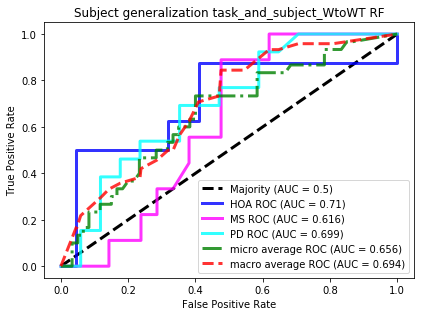

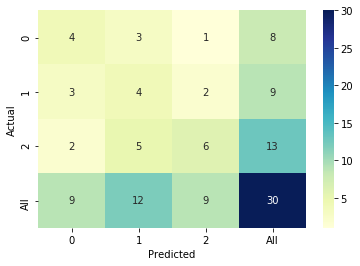

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 150}
Stride-based model performance (mean):  [0.42995636651952485, 0.4559698433709639, 0.4452364127540309, 0.4201009076336586, 0.6792712274300908]
Stride-based model performance (standard deviation):  [0.11820859724404806, 0.11758648457891693, 0.11889646395794408, 0.12401369722822145, 0.08619205674016438]
Person-based model performance (mean):  [0.3904761904761905, 0.4444444444444445, 0.37777777777777777, 0.36444444444444446, 0.6777777777777778]
Person-based model performance (standard deviation):  [0.26538809129700525, 0.2652741419180738, 0.3030707043774634, 0.2553525763950796, 0.15600134535665527]


<Figure size 432x288 with 0 Axes>

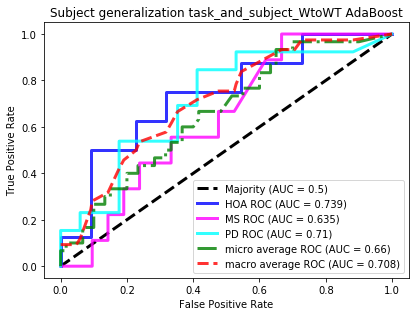

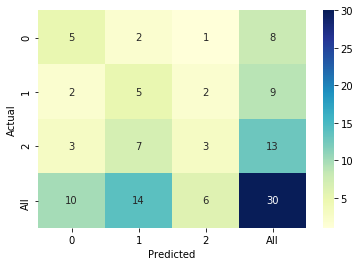

********************************
kernel_svm
best_params:  {'svc__gamma': 0.1}
Stride-based model performance (mean):  [0.366491054866503, 0.49344567696159886, 0.40764871688926824, 0.33606581270366, 0.6505257074183823]
Stride-based model performance (standard deviation):  [0.12708867484438538, 0.13161282521277434, 0.10922985477549182, 0.1432323385044803, 0.08072518432000375]
Person-based model performance (mean):  [0.35952380952380947, 0.4222222222222222, 0.33333333333333337, 0.30126984126984124, 0.6194444444444444]
Person-based model performance (standard deviation):  [0.17535192990020923, 0.12957670877434, 0.31671539586087166, 0.22035588155905192, 0.22815010220423407]


<Figure size 432x288 with 0 Axes>

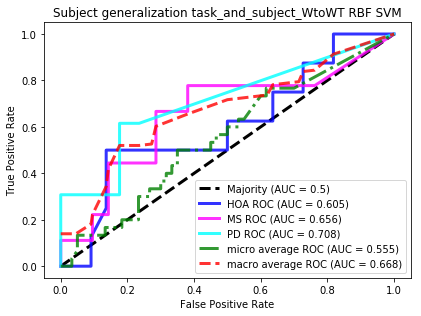

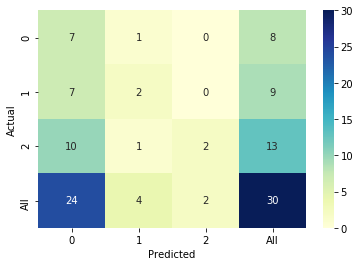

********************************
gbm


In [ ]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics = run_ml_models(ml_models, X_full, Y_full, train_indices, test_indices, framework)

In [ ]:
metrics

#### Task+subject generalization together framework 2: train on virtual beam walking (VBW) and test on virtual beam walking while talking (VBWT) to classify HOA/MS/PD strides and subjects 

In [ ]:
#We are training on some subjects of trial VBW and testing on separate remaining subjects of trial VBWT
train_framework = 'SLW'
test_framework = 'SLWT'

#Extracting the list of PIDs/subjects that are only included in the training set, only included in the testing set 
#and common PIDs in both training and testing sets 
train_pids, test_pids, common_pids = extract_train_test_common_PIDs(data, train_framework, test_framework)
design()


In [ ]:
#Trial VBW for training 
trialVBW = data[data['scenario']==train_framework] #Full trial VBW with all 22 subjects 
#Trial VBWT for testing 
trialVBWT = data[data['scenario']==test_framework] #Full trial VBWT with all 21 subjects 

#Full training data stats 
print ('Number of subjects in trial VBW in each cohort:\n', trialVBW.groupby('PID').first()['cohort'].value_counts())
print('Strides in complete training set: ', len(trialVBW))
print ('HOA, MS and PD strides in complete training set:\n', trialVBW['cohort'].value_counts())
design()

#Full testing data stats 
print ('Number of subjects in trial VBWT in each cohort:\n', trialVBWT.groupby('PID').first()['cohort'].value_counts())
print('Strides in complete testing set: ', len(trialVBWT))
print ('HOA, MS and PD strides in complete testing set:\n', trialVBWT['cohort'].value_counts())
design()

#Training only data with strides from VBW
train_only_trialVBW = trialVBW[trialVBW.PID.isin(train_pids)] #subset of trial W with subjects only present in trial W but not in trial WT
print ('Number of subjects only in trial VBW in each cohort:\n', train_only_trialVBW.groupby('PID').first()['cohort'].value_counts())
print('Strides of subjects only in trial VBW: ', len(train_only_trialVBW))
print ('HOA, MS and PD strides in of subjects only in trial VBW :\n', train_only_trialVBW['cohort'].value_counts())
design()

#Testing only data with strides from VBWT
test_only_trialVBWT = trialVBWT[trialVBWT.PID.isin(test_pids)] #subset of trial WT with subjects only present in trial WT but not in trial W
print ('Number of subjects only in trial VBWT in each cohort:\n', test_only_trialVBWT.groupby('PID').first()['cohort'].value_counts())
print('Strides of subjects only in trial VBWT: ', len(test_only_trialVBWT))
print ('HOA, MS and PD strides in of subjects only in trial VBWT :\n', test_only_trialVBWT['cohort'].value_counts())
design()

#Training data with strides from VBW for common PIDs in trials VBW and VBWT
train_trialVBW_commonPID = trialVBW[trialVBW.PID.isin(common_pids)] #subset of trial VBW with common subjects in trial VBW and VBWT
print ('Number of subjects common to trials VBW and VBWT in each cohort:\n', train_trialVBW_commonPID.groupby('PID').first()['cohort'].value_counts())
print('Strides in trial VBW in each cohort of subjects common to trials VBW and VBWT: ', len(train_trialVBW_commonPID))
print ('HOA, MS and PD strides in trial VBW of subjects common to trials VBW and VBWT:\n', train_trialVBW_commonPID['cohort'].value_counts())
design()

#Testing data with strides from VBWT for common PIDs in trials VBW and VBWT
test_trialVBWT_commonPID = trialVBWT[trialVBWT.PID.isin(common_pids)] #subset of trial VBW with common subjects in trial VBW and VBWT
print ('Number of subjects common to trials VBW and VBWT in each cohort:\n', test_trialVBWT_commonPID.groupby('PID').first()['cohort'].value_counts())
print('Strides in trial VBWT in each cohort of subjects common to trials VBW and VBWT: ', len(test_trialVBWT_commonPID))
print ('HOA, MS and PD strides in trial VBWT of subjects common to trials VBW and VBWT:\n', test_trialVBWT_commonPID['cohort'].value_counts())
design()

In [ ]:
cols_to_drop = ['key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label', 'PID']
X_train_common_VBWtoVBWT = train_trialVBW_commonPID.drop(cols_to_drop, axis = 1)
Y_train_common_VBWtoVBWT = train_trialVBW_commonPID[['PID', 'label']]

train_test_concatenated_VBWtoVBWT = pd.concat([trialVBW, trialVBWT], axis = 0).reset_index().drop('index', axis = 1)

#Shuffling the concatenated data
train_test_concatenated_VBWtoVBWT = shuffle(train_test_concatenated_VBWtoVBWT, random_state = 0)

#Computing the X (91 features), Y (PID, label) for the models 
X_full_VBWtoVBWT = train_test_concatenated_VBWtoVBWT.drop(cols_to_drop, axis=1)
Y_full_VBWtoVBWT = train_test_concatenated_VBWtoVBWT[['PID', 'label']]
print (X_full_VBWtoVBWT.shape, Y_full_VBWtoVBWT.shape) #1176+1651

#Computing the training and test set indices for the CV folds 
train_indices_VBWtoVBWT, test_indices_VBWtoVBWT = compute_train_test_indices_split(train_test_concatenated_VBWtoVBWT,\
                                                                X_train_common_VBWtoVBWT, Y_train_common_VBWtoVBWT, \
                                                               train_pids, test_pids, train_framework, test_framework)
framework = 'task_and_subject_VBWtoVBWT' #Defining the task generalization framework of interest

In [ ]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics_VBWtoVBWT = run_ml_models(ml_models, X_full_VBWtoVBWT, Y_full_VBWtoVBWT, train_indices_VBWtoVBWT, test_indices_VBWtoVBWT,\
                                  framework)

In [ ]:
metrics_VBWtoVBWT